# Fremskrivning af epidemikurven i Danmark

Dette dokument danner en eksponentiel fremskriver epidemikurven ud fra dagsaktuelle tal 
for smittede, indlagt og døde. 

## Metode
Vi anvender eksponentiel fremskrivning.

Det er en meget grovkornet metode, som kun kan bruges til kortsigtede fremskrivninger, da den ikke tager højde for
at epidemien over tid har færre og færre raske at ramme (dvs. at kurven begynder at bue nedad).

Den er dog relevant, da det er en fin måde at vise data på i starten af epidemien og få en idé om den aktuelle vækstrate.

## Datagrundlag

Data er indhentet fra Sundhedsstyrelsens hjemmeside for 
[COVID-19 tal og overvågning](https://www.sst.dk/da/corona/tal-og-overvaagning).

Læs mere om datasættet på https://github.com/covid-19-sim/covid-19.sst.dk

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.optimize

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/covid-19-sim/covid-19.sst.dk/master/covid-19-dk.csv',
                 parse_dates=['Date'])

df.head(1000)

,Date,Tested,Confirmed,Hospitalised,ICU,ICU and ventilator,Death count
0,2020-03-03,508.0,13.0,NaN,NaN,NaN,0.0
1,2020-03-04,592.0,16.0,NaN,NaN,NaN,0.0
2,2020-03-05,685.0,26.0,NaN,NaN,NaN,0.0
3,2020-03-06,809.0,28.0,NaN,NaN,NaN,0.0
4,2020-03-07,912.0,37.0,NaN,NaN,NaN,0.0
5,2020-03-08,1136.0,85.0,NaN,NaN,NaN,0.0
6,2020-03-09,1706.0,295.0,NaN,NaN,NaN,0.0
7,2020-03-10,2501.0,551.0,NaN,NaN,NaN,0.0
8,2020-03-11,3372.0,759.0,NaN,NaN,NaN,1.0
9,2020-03-12,4033.0,804.0,19.0,3.0,0.0,1.0


In [3]:
# Kontroller at data har det forventede format
for c in ['Date', 'Tested', 'Confirmed', 'Hospitalised', 'ICU', 'ICU and ventilator', 'Death count']:
    assert c in df.columns    

In [4]:
# Epidemistarten er den første dato 
EPIDEMI_START = pd.Timestamp("2020-03-12")

df['Day'] = df['Date'] - EPIDEMI_START
df['Day N'] = df['Day'].dt.days


## Faktiske indlæggelser og dødsfald
Datasættet ser således ud når vi tegner graferne med henholdsvis lineær og logaritmisk y-akse.
Husk at en ret linie på logaritmisk y-akse svarer til konstant procentuel daglig tilvækst.   

In [5]:
# Udvælg data vi interesserer os for
OVERSKRIFTER = {'Hospitalised': 'Indlagte', 
                'ICU': 'Intensiv', 
                'ICU and ventilator': 'Intensiv med respirator', 
                'Death count': 'Døde'}

kolonner = list(OVERSKRIFTER.keys())

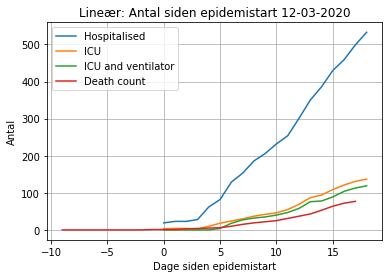

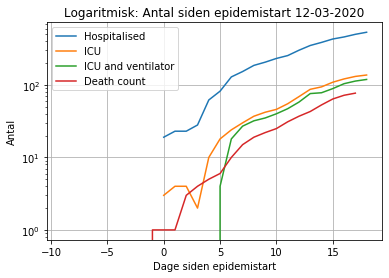

In [6]:
for is_log_plot, titel in [[False, "Lineær"], [True, "Logaritmisk"]]:
    ax = df.plot(x='Day N', y=kolonner, grid=True, logy=is_log_plot,
            title=f'{titel}: Antal siden epidemistart {EPIDEMI_START.date().strftime("%d-%m-%Y")}')
    plt.xlabel('Dage siden epidemistart')
    plt.ylabel('Antal')
    plt.show()

## Eksponentiel fremskrivning

Vi estimerer $a$ og $b$ en simpel eksponentialfunktion til dødsfaldskurven, 

$$\hat{y} = a e^{b x}$$ 

$x$ er dage siden epidemistart, $\hat{y}$ er det estimere antal døde. 

SciPy har en indbygget funktion til at dette, `curve_fit`:

In [7]:
# Hvis ikke vi har observationen, så drop rækken
df_renset = df[['Day N'] + kolonner].dropna()

x_data = df_renset['Day N']

def exp_func(x, a, b):
    return a * np.exp(b * x)

def estimer_a_b(ys):
    """Estimer a og b baseret på alle observationer"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, x_data, ys)
    a,b = popt
    return a,b    

Vi kan også beregne en rullende prognose baseret på kun de nyeste observationer. Dette giver os mulighed for at 
se tendensen.

In [8]:
TENDENS_DAGE = 7

def estimer_tendens(ys):
    """Estimer a og b på bases af de seneste dages observationer (rullende prognose)"""
    popt, pcov = scipy.optimize.curve_fit(exp_func, x_data[-TENDENS_DAGE:], ys[-TENDENS_DAGE:])
    a,b = popt
    return a,b    

In [9]:
# Estimer alle kolonnerne
estimater = {}

for k in kolonner:
    y_data = df_renset[k]
    a, b = estimer_a_b(y_data)
    a_tendens, b_tendens = estimer_tendens(y_data)
    overskrift = OVERSKRIFTER[k]
    print(f'{overskrift:30}: a         = {a}')
    print(f'{overskrift:30}: b         = {b}')
    print(f'{overskrift:30}: a_tendens = {a_tendens}')
    print(f'{overskrift:30}: b_tendens = {b_tendens}')
    print()
    estimater[k] = {'a': a, 'b': b, 'y_data': y_data, 
                    'a_tendens': a_tendens, 'b_tendens': b_tendens} 


Indlagte                      : a         = 54.17290973201392
Indlagte                      : b         = 0.1357735097619465
Indlagte                      : a_tendens = 87.87458909093952
Indlagte                      : b_tendens = 0.10361258737013532

Intensiv                      : a         = 9.39936613594133
Intensiv                      : b         = 0.1600775941527784
Intensiv                      : a_tendens = 15.002357401142065
Intensiv                      : b_tendens = 0.12964563367176185

Intensiv med respirator       : a         = 6.898027003333719
Intensiv med respirator       : b         = 0.16964763825649948
Intensiv med respirator       : a_tendens = 12.268836151380482
Intensiv med respirator       : b_tendens = 0.1321521623053015

Døde                          : a         = 4.326159972527997
Døde                          : b         = 0.17446364436392306
Døde                          : a_tendens = 6.349347787839214
Døde                          : b_tendens = 0.149646763

Den daglige vækstrate er $${{\hat{y}_{t+1}}\over\hat{y}_t} = e^b$$ hvor $t$ angiver dage siden epidemistart.

In [10]:
# Vis den daglige vækstrate
for k in kolonner:
    daglig_vaekstrate = np.exp(estimater[k]['b'])
    print(f'{OVERSKRIFTER[k]:30}: Daglig vækst i antal: {int(100*(daglig_vaekstrate-1))}%')

Indlagte                      : Daglig vækst i antal: 14%
Intensiv                      : Daglig vækst i antal: 17%
Intensiv med respirator       : Daglig vækst i antal: 18%
Døde                          : Daglig vækst i antal: 19%


In [11]:
# Højeste dato med en faktisk observation, herefter følger prognosen
day_N_max = int(np.max(x_data))
date_max = datetime.timedelta(days=day_N_max) + EPIDEMI_START

FREMSKRIV_DAGE = 14
x_data_alle = np.arange(0, day_N_max+FREMSKRIV_DAGE+1)
x_data_fremskrivning = x_data_alle[-FREMSKRIV_DAGE-1:]

Så er vi klar til at tegne grafer med data og prognoser:

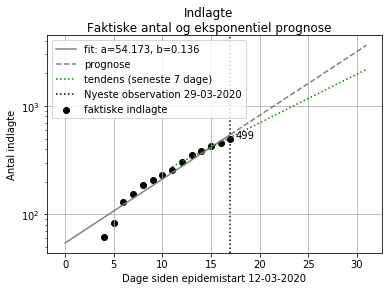

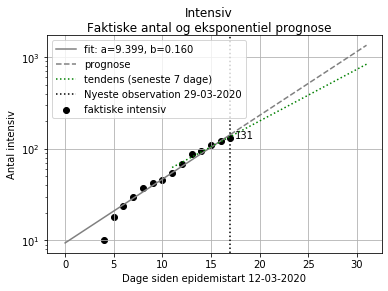

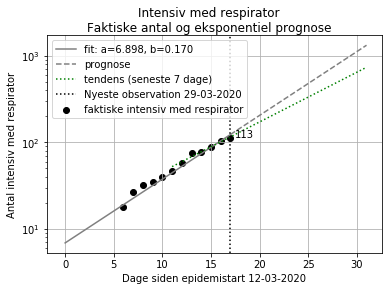

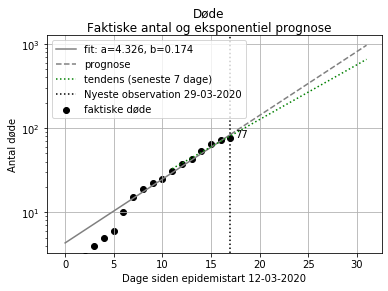

In [12]:
for k in kolonner:
    a = estimater[k]['a']
    b = estimater[k]['b']
    a_tendens = estimater[k]['a_tendens']
    b_tendens = estimater[k]['b_tendens']
    y_data = estimater[k]['y_data']
    overskrift = OVERSKRIFTER[k] 

    y_data_fremskrivning = exp_func(x_data_fremskrivning, a, b)

    x_data_tendens_fremskrivning = x_data_alle[-(TENDENS_DAGE+FREMSKRIV_DAGE):]
    y_data_tendens_fremskrivning = exp_func(x_data_tendens_fremskrivning, a_tendens, b_tendens)
    
    plt.plot(x_data, exp_func(x_data, a, b), c='grey', ls='-', label='fit: a=%5.3f, b=%5.3f' % (a,b))
    plt.plot(x_data_fremskrivning, y_data_fremskrivning, c='grey', ls='--', label='prognose')
    plt.scatter(x_data, y_data, c='black', label=f'faktiske {overskrift.lower()}')
    plt.plot(x_data_tendens_fremskrivning, y_data_tendens_fremskrivning, c='green', ls=':', label=f'tendens (seneste {TENDENS_DAGE} dage)')
    
    nyeste_xy = (x_data.to_list()[-1] + .5, y_data.to_list()[-1])
    plt.annotate(f'{int(nyeste_xy[1])}', nyeste_xy) 
    
    plt.xlabel(f'Dage siden epidemistart {EPIDEMI_START.strftime("%d-%m-%Y")}')
    plt.ylabel(f'Antal {overskrift.lower()}')
    plt.axvline(day_N_max, color='k', linestyle=':', 
                label=f'Nyeste observation {date_max.date().strftime("%d-%m-%Y")}')
    plt.legend()
    plt.suptitle(f'{overskrift}\nFaktiske antal og eksponentiel prognose')
    plt.yscale('log')
    plt.grid()
    
    plt.show()